## Visualise GRAPPA kernels
###### Author: Zimu Huo
###### Date: 02.2022

Convolution in k space is multiplication in image space, so why not transform the kernels into image space


-------------------------------------------------------------------------
References
    
    [1] 
    Author: Mark A. Griswold et al. 
    Title: Generalized Autocalibrating Partially Parallel Acquisitions (GRAPPA)
    Link: https://pubmed.ncbi.nlm.nih.gov/12111967/
    

In [1]:
import sys
sys.path.insert(1, '../')
import numpy as np
import matplotlib.pyplot as plt
from util.coil import *
import util.mask as undersample
from util.fft import *
import util.simulator as simulate
from util.grappa import *

In [2]:
data = data = np.load("../lib/slice1_grappa1.npy")
rawImage = ifft2c(data)
acs = simulate.acs(data, (32, 32))
dataR = np.zeros(data.shape, dtype = complex)
R = 2
dataR[::R] = data[::R]

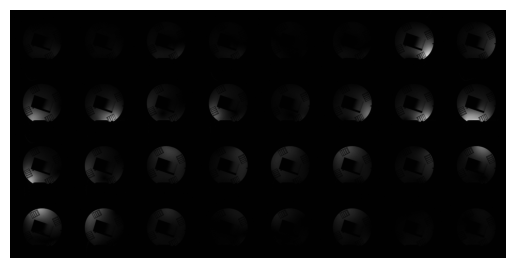

In [3]:
show(stitch(ifft2c(data),4))

In [4]:
def grappa1_weights(calib, R, kh = 4, kw = 5, lamda = 0.01):
    calib = np.moveaxis(calib, -1, 0) # move the coil to the front -> fft in the axis 3 and 4
    [nc, ncy, ncx] = calib.shape
    ks = nc*kh*kw
    nt = (ncy-(kh-1)*R)*(ncx-(kw-1))
    inMat=np.zeros([ks,nt], dtype = complex)
    outMat=np.zeros([nc*R,nt], dtype = complex)
    n = 0
    for x in (np.arange(np.floor(kw/2),ncx-np.floor(kw/2), dtype=int)):
        for y in (np.arange(ncy-(kh-1)*R)):
            inMat[...,n] = calib[:,y:y+kh*R:R, int(x-np.floor(kw/2)):int(x+np.floor(kw/2))+1].reshape(1,-1)
            outMat[...,n] = calib[:,int(y+np.floor((R*(kh-1)+1)/2) - np.floor(R/2)):int(y+np.floor((R*(kh-1)+1)/2)-np.floor(R/2)+R),x].reshape(1,-1)
            n = n + 1  
    #wt =  outMat@pinv(inMat, 1E-4)
    inMat = inMat.T
    outMat = outMat.T
    AHA = inMat.conj().T @ inMat
    S = np.sqrt(max(np.abs(np.linalg.svd(AHA,compute_uv=False))))
    wt = np.linalg.solve(
        AHA + (lamda*S)*np.eye(AHA.shape[0]), inMat.conj().T @ outMat).T
    wt = wt.reshape(nc,R,nc,kh,kw)
    return wt

def grappa1(data, acs, kh = 4, kw = 5, lamda = 0.1,combine = True, wt= None, v= 0, R=None):
    if R is None:
        mask = np.where(data[:,0,0] == 0, 0, 1).flatten()
        R = int(np.ceil(mask.shape[0]/np.sum(mask)))
    if v:
        print("undersample factor of "+str(R))
    [ny, nx, nc] = data.shape
    
    #train
    if wt is None:
        wt = grappa1_weights(acs,R,kh,kw, lamda)
    wt = np.flip(np.flip(wt.reshape(nc,R,nc,kh,kw),axis=3),axis=4)
    w = np.zeros([nc, nc, kh*R, kw], dtype = complex)
    for r in range(R):
        w[:,:,r:R*kh:R,:] = wt[:,r,:,:,:]
    del wt
    ws_k = np.zeros([nc, nc, ny, nx], dtype = complex)
    ws_k[:,:,math.ceil((ny-kh*R)/2):math.ceil((ny+kh*R)/2),math.ceil((nx-kw)/2):math.ceil((nx+kw)/2)] = w
    wim = ifft2c(ws_k, axis = (2,3))
    return wim



In [5]:
kernels = grappa1(dataR, acs)

In [6]:
nc, nc, ny, nx= kernels.shape
kernels = np.moveaxis(kernels, 0, -1)
kernels = np.moveaxis(kernels, 0, -1)

In [12]:
# only draw a few
kernels = kernels[:,:,:4,:4]

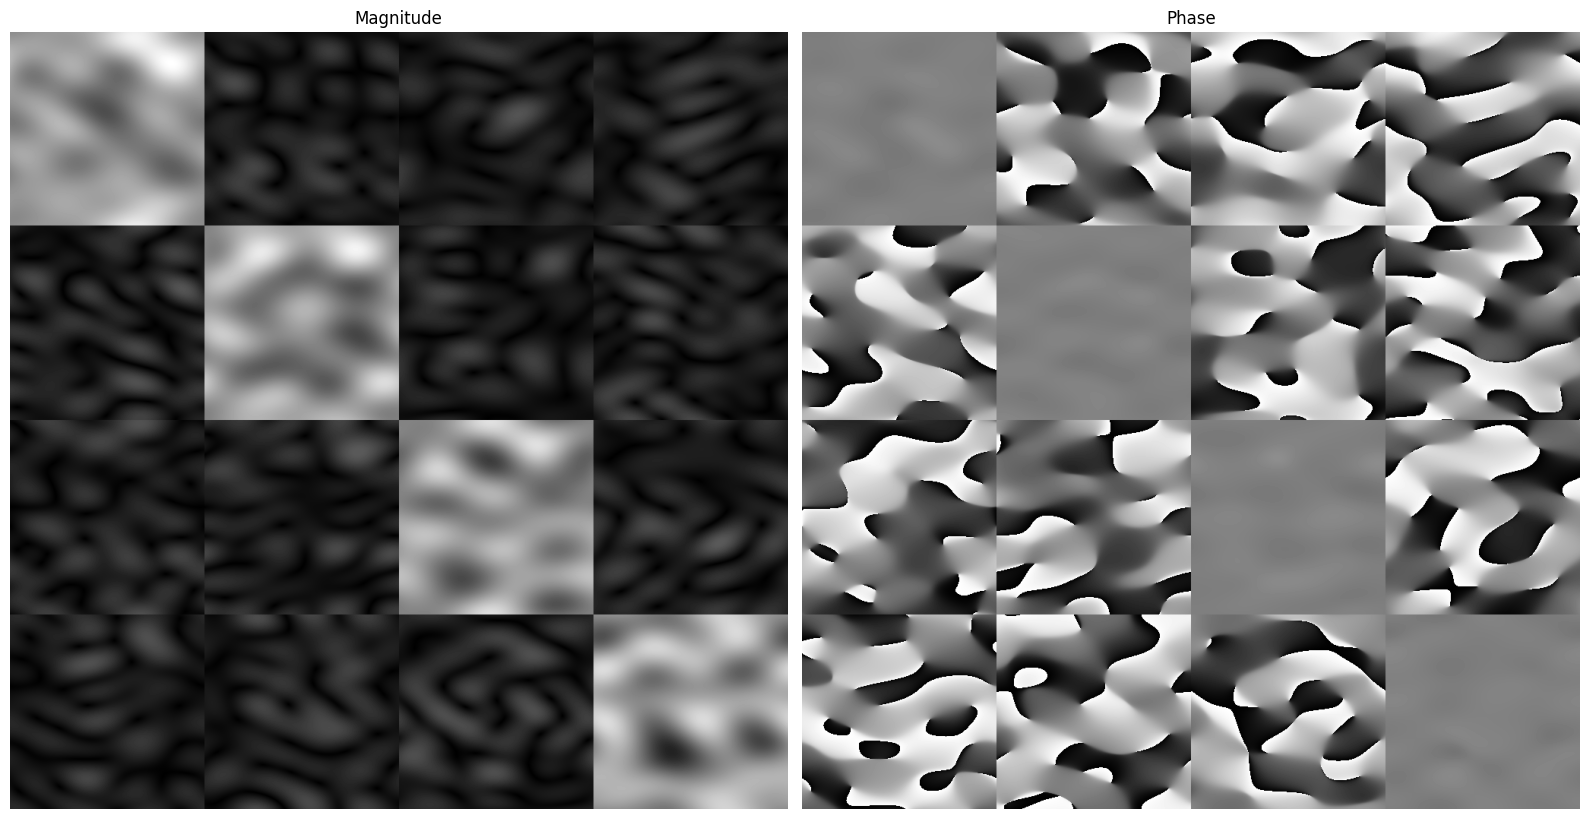

In [13]:
plt.figure(figsize = (16,12))
plt.subplot(121)
plt.title("Magnitude")
plt.imshow(np.abs(stitch(kernels.reshape(ny,nx,-1),4)), cmap ="gray")
plt.axis('off')
plt.subplot(122)
plt.title("Phase")
plt.imshow(np.angle(stitch(kernels.reshape(ny,nx,-1),4)), cmap ="gray")
plt.axis('off')
plt.tight_layout()
plt.show()